# Getting the data

In [1]:
import pandas as pd

data = pd.read_csv('Codeacademy_Webscrapper_20210107154307.csv')
data.head()

,Unnamed: 0,Topic Title,Category,Tags,Leading Comment,Other Comments,Likes,Views
0,0,[How to] Format code in posts,Getting Started,[],Codecademy Discuss posts are parsed with Markd...,[],21,13.9k
1,1,Guide: A list of how-to’s for giving and recei...,Getting Started,[],Technical guides will teach you how to use the...,[],0,0
2,2,Guide: Learn about our community forums,Getting Started,[],Take a moment and read through each of these b...,[],0,0
3,3,[How-to] Create a topic that everyone will read,Getting Started,[],A great topic is one that provides potential h...,[],0,0
4,4,[Learn More] How the forum is organized,Getting Started,[],"With Codecademy Community forums, conversation...",[],0,0


# Explore the data

In [2]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

In [3]:
df = data.copy()

In [4]:
df['text'] = df['Topic Title'] + ' ' + df['Tags'] + ' ' + df['Leading Comment']

In [5]:
df['Category'].unique()

array(['Getting Started', 'Get Help', 'Community', 'Projects', 'FAQ'],
      dtype=object)

In [6]:
df.drop(df.loc[df['Category']=='Getting Started'].index, inplace=True)
df['Category'].unique()

array(['Get Help', 'Community', 'Projects', 'FAQ'], dtype=object)

Text(0, 0.5, 'no of posts')

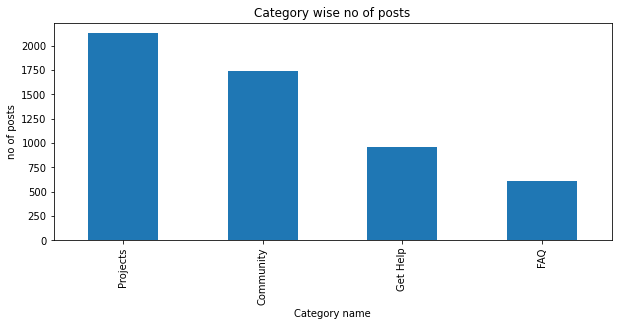

In [7]:
my_categories = ['Get Help',
       'Community', 'Projects', 'FAQ']
plt.figure(figsize=(10,4))
df.Category.value_counts().plot(kind='bar');
# Add title and axis names
plt.title('Category wise no of posts')
plt.xlabel('Category name')
plt.ylabel('no of posts')

In [8]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\'\“\”\’\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
DIGITS_RE=re.compile('\w*\d\w*')

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = text.replace(r'\n', ' ')
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    #text = ''.join(word for word in text if word not in punct)  # remove punctuation
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    text = DIGITS_RE.sub('', text)
    return text

In [9]:
df['text']=df['text'].apply(clean_text)

In [10]:
df_x = df['text']
df_y = df['Category']

# Building the Machine Learning model & pipeline

### Converting to Doc2Vec

In [11]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(clean_text(row).split(), [index]) for index, row in enumerate(df_x)]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(clean_text(row).split())
                                     for index, row in enumerate(df_x)]))

In [12]:
doc2vec_trf = Doc2VecTransformer()
doc2vec_features = doc2vec_trf.fit(df_x).transform(df_x)
doc2vec_features

100%|██████████████████████████████████████████████████████████████████████████████████████| 5438/5438 [00:00<?, ?it/s]


matrix([[-4.72816965e-03, -2.84944917e-03,  3.56974849e-03, ...,
          4.69671469e-03,  8.02068796e-04,  4.34946315e-03],
        [ 3.72387259e-03,  3.80354119e-03, -3.06721614e-03, ...,
          6.07398397e-04,  3.73286987e-03, -9.43814637e-04],
        [-2.93252796e-01, -5.37579060e-01, -4.02580202e-01, ...,
         -6.84932107e-04,  7.69210905e-02,  6.74205542e-01],
        ...,
        [ 1.15434546e-03, -6.71076239e-04, -1.30216870e-03, ...,
          4.75814939e-03, -2.12510535e-03, -1.59308780e-03],
        [-4.55362024e-03, -1.49201199e-01, -8.41621906e-02, ...,
         -6.00798335e-03,  1.11271329e-02,  8.63768905e-02],
        [-6.24870174e-02, -7.74535015e-02, -8.15281644e-02, ...,
          2.55655497e-02,  6.39082305e-03,  1.21168174e-01]],
       dtype=float32)

# Pipeline with Doc2Vec & LogisticRegression

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

pl_log_reg = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Logistic Regression: ', scores.mean())

100%|██████████████████████████████████████████████████████████████████████████████████████| 4350/4350 [00:00<?, ?it/s]
c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
100%|██████████████████████████████████████████████████████████████████████████████████████| 4350/4350 [00:00<?, ?it/s]
c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
100%|██████████████████████████████████████████████████████████████████████████████████████| 4350/4350 [00:00<?, ?it/s]
c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which 

Accuracy for Logistic Regression:  0.39444910438876557


# Pipeline with Doc2Vec & RandomForest

In [14]:
from sklearn.ensemble import RandomForestClassifier

pl_random_forest = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                                   ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for RandomForest : ', scores.mean())

100%|██████████████████████████████████████████████████████████████████████████| 4351/4351 [00:00<00:00, 278544.75it/s]


Accuracy for RandomForest :  0.37734320038963143


# Pipeline with Doc2Vec & XGBoost

In [15]:
import xgboost as xgb

pl_xgb = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb, df_x, df_y, cv=5)
print('Accuracy for XGBoost Classifier : ', scores.mean())

100%|██████████████████████████████████████████████████████████████████████████████████████| 4350/4350 [00:00<?, ?it/s]
c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:45:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████████████████████████████████████████████████████████████████████| 4350/4350 [00:00<00:00, 543854.25it/s]


[14:46:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████████████████████████████████████████████████████████████████████████████████| 4350/4350 [00:00<?, ?it/s]


[14:47:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████████████████████████████████████████████████████████████████████████████████| 4351/4351 [00:00<?, ?it/s]


[14:47:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████████████████████████████████████████████████████████████████████████████████| 4351/4351 [00:00<?, ?it/s]


[14:48:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy for XGBoost Classifier :  0.36631480329022137


# Converting to Tf-Idf

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

class Text2TfIdfTransformer(BaseEstimator):

    def __init__(self):
        self._model = TfidfVectorizer()
        pass

    def fit(self, df_x, df_y=None):
        df_x = df_x.apply(lambda x : clean_text(x))
        self._model.fit(df_x)
        return self

    def transform(self, df_x):
        return self._model.transform(df_x)

In [17]:
tfidf_transformer = Text2TfIdfTransformer()
tfidf_vectors = tfidf_transformer.fit(df_x).transform(df_x)

In [18]:
tfidf_vectors.shape

(5438, 41637)

In [19]:
print(tfidf_vectors)

  (0, 38929)	0.18068562186039805
  (0, 37293)	0.17581592712357982
  (0, 35360)	0.16781350268998504
  (0, 35354)	0.20409551595352485
  (0, 35211)	0.0856295661048488
  (0, 34746)	0.16213569219616275
  (0, 34604)	0.10204775797676242
  (0, 31852)	0.09127331894209549
  (0, 29985)	0.0974566296595979
  (0, 29077)	0.24472890337198072
  (0, 29024)	0.06861691736331577
  (0, 27638)	0.11526358542830918
  (0, 27550)	0.11669093544611675
  (0, 27515)	0.07752514450838847
  (0, 26781)	0.11151280751724778
  (0, 26204)	0.31953191050460855
  (0, 25327)	0.1324506084015562
  (0, 25109)	0.05572976978054955
  (0, 23910)	0.1125535443890543
  (0, 22071)	0.09708771411312736
  (0, 21975)	0.07772966869188806
  (0, 20669)	0.11770328078503309
  (0, 20424)	0.16781350268998504
  (0, 20402)	0.07952186171500425
  (0, 19912)	0.2538976977190078
  :	:
  (5437, 22759)	0.12054224637975437
  (5437, 22457)	0.16607465309808864
  (5437, 20476)	0.16607465309808864
  (5437, 19766)	0.11218977083449157
  (5437, 19595)	0.072415002005

# Pipeline with Tf-Idf & LogisticRegression

In [20]:
pl_log_reg_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                                    ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & Logistic Regression: ', scores.mean())

Accuracy for Tf-Idf & Logistic Regression:  0.806902260674279


# Pipeline with Tf-Idf & RandomForest

In [21]:
pl_random_forest_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                                          ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & RandomForest : ', scores.mean())

Accuracy for Tf-Idf & RandomForest :  0.8153633854645814


# Pipeline with Tf-Idf & XGBoost

In [22]:
pl_xgb_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb_tf_idf, df_x, df_y, cv=5)
print('Accuracy for Tf-Idf & XGBoost Classifier : ', scores.mean())

c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:50:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:50:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:50:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

### Best accuracy: 85.54% by pipeline with Tf-Idf & XGBoost